# Imports

In [45]:
!cat /proc/meminfo | grep Mem

MemTotal:       1056246168 kB
MemFree:        800346588 kB
MemAvailable:   1027012716 kB


In [46]:
import multiprocessing

multiprocessing.cpu_count()

32

In [47]:
101179816 /1024**2

96.49259185791016

In [48]:
import pickle

In [49]:
from typing import Union, List

In [6]:
import pandas as pd
import numpy as np
import os, sys
import warnings
import random
import json
import dill
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# f = os.path.dirname(__file__)
sys.path.append(os.path.join(os.getcwd(), "../.."))
from tqdm import tqdm
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, auc, roc_curve, \
    balanced_accuracy_score, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from scipy import stats
import networkx as nx
from collections import defaultdict
from sklearn.decomposition import PCA
import pickle
# import dill
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import igraph as ig

from detection.detection_utils.factory import create_dir_if_missing
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

# sns.set(rc={'figure.figsize': (10, 10)}, font_scale=1.4)
from scipy.optimize import minimize
from utils.my_timeit import timeit
from utils.general import init_log

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, multivariate=True, group=True, warn_independent_sampling=False ,**optuna.samplers.TPESampler.hyperopt_parameters())

logger = init_log("user_level_simple_models")

os.chdir('/sise/home/tommarz/hate_speech_detection/')
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

# Helper Functions

In [7]:
def expect_precision(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    # idxs = np.where(y_prob < thres)[0]
    # fn = y_prob[idxs].sum()
    return tp/(tp+fp)

def expect_f1(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_true, y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_true, y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres #, f1s 

def get_hs_count(current_preds, threshold=0.5):
    return len(current_preds[current_preds > threshold])

def calc_metrics(y_true, y_pred):
    return {f.__name__:f(y_true, y_pred) for f in scoring_list}

def write_method_params_and_results(method_name, output_path, results_dict, overwrite=False):
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    for name, df in results_dict.items():
        path = os.path.join(output_path, f'{method_name}_{name}_results')
        # print(results_path)
        if not os.path.exists(f'{path}.csv') or overwrite:
            df.to_csv(f'{path}.csv')
        else:
            print(f'{name}.csv file already exists')
        if name != 'params':
            if (not os.path.exists(f'{path}.txt') or overwrite):
                np.savetxt(f'{path}.txt', df.values.T, fmt='%.3f', delimiter = ' & ')
            else:
                print(f'{name}.txt file already exists')

def read_method_params_and_results(method_name, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    params_path = os.path.join(output_path, f'{method_name}_best_params.txt')
    train_results_path = os.path.join(output_path, f'{method_name}_train_results.csv')
    test_results_path = os.path.join(output_path, f'{method_name}_test_results.csv')
    with open(params_path, 'r') as f:
        best_params = json.load(f)
    train_results = pd.read_csv(train_results_path)
    test_results = pd.read_csv(test_results_path)
    metrics_dict = {'train': train_results, 'test': test_results}
    return best_params, metrics_dict

def get_best_results_cv(results_cv, scoring_name=None, best_score_idx=None):
    scores_mean = results_cv.mean(axis=0)
    scores_std = results_cv.std(axis=0)
    
    if scoring_name is not None and best_score_idx is None:
        scoring_idx = get_scoring_idx_by_name(scoring_name)    
        scoring_mean = scores_mean[scoring_idx]
        scoring_std = scores_std[scoring_idx]
        best_score_idx = scoring_mean.argmax() if not best_score_idx else best_score_idx
    
        best_scores_mean = scores_mean[:, best_score_idx]
        best_scores_std = scores_std[:, best_score_idx]
        results_df = pd.DataFrame([best_scores_mean, best_scores_std], columns=scoring_names, index=['mean', 'std']).T

        return results_df, best_score_idx
    
    best_scores_mean = scores_mean[:, best_score_idx]
    best_scores_std = scores_std[:, best_score_idx]
    results_df = pd.DataFrame([best_scores_mean, best_scores_std], columns=scoring_names, index=['mean', 'std']).T
    
    return results_df

def get_scoring_idx_by_name(name):
    return [idx for idx, e in enumerate(scoring_list) if name in e.__name__][0]

def write_results_latex(df, name):
    with open(os.path.join(method_output_path, f'{method_name}_{name}_results_latex.txt'), 'w') as f:
        res = ' & '.join([f'${m:.3f} \pm {s:.3f}$' for m, s in df.values.reshape(-1, 2)]) + '\\\\'
        f.write(res)

def get_best_results_from_gs(gs):
    train_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[
                                     gs.best_index_, [c for c in gs.cv_results_ if
                                                      'mean_train' in c or 'std_train' in c]].values.reshape(-1, 2),
                                 columns=['mean', 'std'], index=scoring_names)
    test_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if
                                                                                            'mean_test' in c or 'std_test' in c]].values.reshape(
        -1, 2), columns=['mean', 'std'], index=scoring_names)
    # best_hyper_params = pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    return {'train': train_results, 'test': test_results}

def get_best_results_from_cv_results(cv_results):
    train_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_train' in c or 'std_train' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    test_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_test' in c or 'std_test' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    return {'train': train_results, 'test': test_results}

def write_best_results_and_params_from_gs(gs):
    results_dict = get_best_results_from_gs(gs)
    pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    pd.Series(gs.best_estimator_.get_learned_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_params.csv'))

    for name, df in results_dict.items():
        write_results_latex(df, name=name)
        df.to_csv(os.path.join(method_output_path, f'best_results_{name}.csv'))
        
    return results_dict

In [8]:
f1_scores_lst = ['f1',
'f1_macro',
'f1_micro',
'f1_samples',
'f1_weighted']

In [9]:
scoring_list = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scoring_names = ['_'.join(f.__name__.split('_')[:-1]) for f in [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]]
scoring_dict = {n:f for n, f in zip(scoring_names, scoring_list)}
# scoring_dict

In [10]:
get_hs_count_vec = FunctionTransformer(lambda x, post_threshold: np.vectorize(lambda p, post_threshold: (p>=post_threshold).sum())(x))
get_mean_hs_preds_vec = np.vectorize(lambda p: p.mean())

In [11]:
class HateSpeechCountTransformer(FunctionTransformer):
    def __init__(self, post_threshold=0.5):
        super().__init__()
        self.post_threshold=post_threshold
        self.f = np.vectorize(lambda p, post_threshold: (p>=post_threshold).sum())
        # self.feature_names_out = lambda self, input_features: ['hs_count']
        # self.feature_names_out = 'one_to_one'
    
    def transform(self, X):
        return self.f(X, self.post_threshold).reshape(-1, 1)
        
#     def fit_transform(self, X):
#         return self.transform(X)

In [12]:
class MeanHateSpeechProbaTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__()
        self.f = np.vectorize(lambda p: p.mean())
        # self.feature_names_out = lambda self, input_features: ['mean_hs']
        # self.feature_names_out = 'one_to_one'
    
    def transform(self, X, y=None):
        return self.f(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

In [13]:
def get_ego_subgraph(g, vertices, order_k = 1):
    ego_network = g.neighborhood(vertices=vertices, order=order_k, mode='out')
    set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
    flattened_set = list({element for tupl in set_of_tuples for element in tupl})
    ego_subgraph = g.subgraph(flattened_set)
    return ego_subgraph

In [14]:
def get_user_labels(dataset):
    # if dataset in labels_dict:
    #     return labels_dict[dataset]
    user2label_path = user_level_conf[dataset]["data_path"]
    sep = ","
    if user2label_path.endswith("tsv"):
        sep = "\t"
    y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
    y.index = y.index.astype('str')
    labels_dict[dataset] = y
    return y

In [15]:
def get_labeled_nodes(dataset: str = '', g: ig.Graph = None):
    if dataset == '' and g is not None:
        dataset = g['name']
    elif g is None and dataset!='':
        g = graphs_dict[dataset]
    else:
        raise ValueError("Both @dataset and @g can't be empty")
    # y = get_user_labels(dataset)
    labeled_nodes = g.vs.select(lambda v:  v['label'] != -1)
    return labeled_nodes

# Config

In [16]:
path_conf = {
    'echo_2': {'reposts': "/sise/Yalla_work/data/echoes/only_english/dfs_and_dicts/el_echo_users_rt.txt",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p"},
    'parler': {'reposts': "/sise/Yalla_work/data/parler/echos_edge_dict.p",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/ParlerData/Doc2Vec100.p"},
    'gab': {'reposts': "/sise/home/tommarz/hate_speech_detection/hate_networks/outputs/gab_networks/network_data/edges/retweet_edges_df.tsv",
     'doc_vectors': "/sise/home/tommarz/Hateful-users-detection/Dataset/GabData/Doc2Vec100.p"},
    'truth': {'reposts': "/sise/home/tommarz/truth_social/truth_social_retruths_weighted_edge_df.tsv"}
}

In [17]:
labels_dict = {}

## Dataset

In [18]:
with open('detection/experiments/sna/largest_component_dict.pkl', 'rb') as f:
    largest_component_dict = pickle.load(f)

In [19]:
dataset = 'echo_2'  # user_level_execution_config["inference_data"]
logger.info(f"loading dataset {dataset}...")
model_name = post_level_execution_config["kwargs"]["model_name"]
# user2pred = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level/split_by_posts/no_text/")

2024-05-02 16:59:40,731 - INFO     - user_level_simple_models - loading dataset echo_2...


In [20]:
user2pred = pd.read_parquet(f'detection/outputs/{dataset}/{model_name}/user_level/split_by_posts/with_text')
if dataset == 'parler':
    user2pred = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level_2500_users/split_by_posts/no_text/")
    # user2pred_old = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level_2500_users/split_by_posts/no_text/")
    # user2pred = pd.concat([user2pred, user2pred_old])
# user2pred['user_id'] = user2pred['user_id'].astype(int)
user2label_path = user_level_conf[dataset]["data_path"]
sep = ","
if user2label_path.endswith("tsv"):
    sep = "\t"
y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
y.index=  y.index.astype(str)
user2pred['user_id'] = user2pred['user_id'].astype(str)
# user2pred = user2pred[user2pred['user_id'].isin(labeled_users.index)]
labeled_user2pred = user2pred.query('`user_id` in @y.index')

predictions_output_path = os.path.join(post_level_execution_config["evaluation"]["output_path"], 'predictions.tsv')
predictions_df = pd.read_csv(predictions_output_path, sep='\t')
y_true = predictions_df['y_true']
y_prob = predictions_df['y_score']
y_pred = predictions_df['y_pred']

print(f'Percent HS Users: {y.mean()}')
# print(f'Percent HS Users: {y_test.mean()}')

Percent HS Users: 0.154


In [21]:
g = largest_component_dict[dataset]
g.summary()

'IGRAPH DNW- 4929 29943 -- echo_2\n+ attr: name (g), label (v), name (v), weight (e)'

In [22]:
user_key = user_level_conf[dataset]['user_unique_column']
user_key

'user_id'

In [23]:
user2pred_flat = user2pred.groupby('user_id').agg(list)

In [24]:
# user2pred_flat['text'] = user2pred_flat['text'].apply(np.array)
user2pred_flat['predictions'] = user2pred_flat['predictions'].apply(np.array)

In [25]:
g.vs['predictions'] = [user2pred_flat.loc[v['name']]['predictions'] if v['name'] in user2pred_flat.index else np.array([]) for v in g.vs]
# g.vs['posts'] = [user2pred_flat.loc[v['name']]['text'] if v['name'] in user2pred_flat.index else [] for v in G.vs]

In [26]:
g.summary()

'IGRAPH DNW- 4929 29943 -- echo_2\n+ attr: name (g), label (v), name (v), predictions (v), weight (e)'

In [27]:
labeled_nodes = get_labeled_nodes(g=g)
len(labeled_nodes)

233

In [28]:
def get_hs_count(g, post_threshold=0.5):
    labeled_nodes = get_labeled_nodes(g=g)
    df = pd.DataFrame(columns=['node_id', 'hs_count', 'average_followees_hs_count', 'average_followers_hs_count'])
    for v in tqdm(labeled_nodes):
        v['hs_count'] = (v['predictions']>post_threshold).sum()
        v['average_followees_hs_count'] = np.mean([(v['predictions']>post_threshold).sum() for v in g.vs[g.neighbors(v, mode='out')]])
        # v['average_followees_hs_count'] = 0 if np.isnan(v['average_followees_hs_count']) else v['average_followees_hs_count']
        v['average_followers_hs_count'] = np.mean([(v['predictions']>post_threshold).sum() for v in g.vs[g.neighbors(v, mode='in')]])
        # v['average_followers_hs_count'] = 0 if np.isnan(v['average_followers_hs_count']) else v['average_followers_hs_count']
        s = pd.DataFrame([v['name'], v['hs_count'], v['average_followees_hs_count'], v['average_followers_hs_count']], index=['node_id', 'hs_count', 'average_followees_hs_count', 'average_followers_hs_count']).T
        df = pd.concat((df,s), ignore_index=True)
    return df.set_index('node_id')

In [29]:
# try:
#     nodes = user2pred_flat.index.astype(int).tolist()
# except Exception as e:
nodes = user2pred_flat.index.astype(str).tolist()

## Post Threshold

In [30]:
# def optimal_threshold(y_true, y_prob):
y_prob = np.sort(y_prob)[::-1]
precisions = [expect_precision(y_true, y_prob, p) for p in y_prob]
thres = y_prob[np.argmax(precisions)]
thres

0.9950218

In [31]:
post_threshold = optimal_threshold(y_true, y_prob)
# post_threshold=0.9
# post_threshold=thres
post_threshold

0.4196834

## Scoring 

In [32]:
# post_threshold=0.5
# post_threshold = 0.9
scoring_name = 'f1'
scoring = scoring_dict[scoring_name]
scoring_idx = get_scoring_idx_by_name(scoring_name)

## Random State (Seed)

In [33]:
echo_seed = 1524604541
parler_seed = 1740177118
gab_seed = 1524604541

In [34]:
seed = parler_seed if dataset == 'parler' else (echo_seed if dataset == 'echo_2' else gab_seed) # random.randrange(2 ** 32)
print("Seed is:", seed)
output_path = f"detection/outputs/{dataset}/{model_name}/user_level/experiments/{seed}"
if os.path.exists(output_path):
    print(f"Output path {output_path} already exists.")
else:
    os.makedirs(output_path)
    print(f"Output path {output_path} created.")

Seed is: 1524604541
Output path detection/outputs/echo_2/BertFineTuning/user_level/experiments/1524604541 already exists.


In [35]:
best_th = optimal_threshold(y_true, y_prob)
best_th

0.4196834

In [36]:
test_size = 0.2
cv = 5

## Load Network Data
Edge Key: 0 = Repost, 1 = Reply, 2 = Mention

In [37]:
node_names = set(g.vs['name'])

In [38]:
labeled_users = labeled_user2pred['user_id'].unique().tolist() 
# labeled_users = set(labeled_users).intersection(set(doc_vectors))
y = y.loc[labeled_users]

In [39]:
X = user2pred_flat.loc[y.index]
X

text  \
user_id                                                         
231597325   [@loeyjee Iration-Falling. #Acoustic #uniform ...   
2190420108  [#NewMusic 1862 by @VitoBrown ft Tha Bank Arti...   
548007350   [https://t.co/ztsbvCU73A, @adrinkk nice meme l...   
113526237   [Ghost shark video shot by Monterey Bay resear...   
716664192   [Always so much fun hanging out with friends, ...   
...                                                       ...   
225298549   [https://t.co/Ymj5DlMB5s, https://t.co/6s0rZLt...   
460453341   [PLZ RT: #Denver, can you help us locate 91yo ...   
88994026    [55 minute webinar shows 10 proven prospecting...   
187450820   [Nah. ♫ https://t.co/CTlze8dC1b, the saddest t...   
2974346781  [War? https://t.co/Wkl2ZULc6E, "Generation KKK...   

                                                  predictions  
user_id                                                        
231597325   [0.014254283159971237, 0.0036554604303091764, ...  
2190420108  [0.006928810849785805, 0.007612289860844612, 0...  
548007350   [0.00188999914098531, 0.010226309299468994, 0....  
113526237   [0.0021909954957664013, 0.0018158451421186328,...  
716664192   [0.0017960311379283667, 0.0013771638041362166,...  
...                                                       ...  
225298549   [0.00188999914098531, 0.00188999914098531, 0.0...  
460453341   [0.03182728961110115, 0.03574545681476593, 0.0...  
88994026    [0.00253976508975029, 0.005763907451182604, 0....  
187450820   [0.002421223558485508, 0.002108832821249962, 0...  
2974346781  [0.01687876135110855, 0.045864399522542953, 0....  

[1000 rows x 2 columns]

# Train Classifier

## Logistic Regression

### Without Relational Features

In [40]:
100*np.mean(labeled_nodes['label']).round(4), len(labeled_nodes['label'])

(25.97, 847)

In [41]:
hs_count_df = get_hs_count(g, best_th)
hs_count_df

100%|██████████| 847/847 [00:01<00:00, 631.73it/s]


hs_count average_followees_hs_count average_followers_hs_count
node_id                                                                       
Mcmlv2                20                   0.361963                        0.0
Jazzlm                18                   0.227679                        NaN
Djanides              10                        0.0                        NaN
Jsnwaugh               4                        0.0                        NaN
PJW                    8                        NaN                    0.47956
...                  ...                        ...                        ...
Marcolewr2008          0                        0.0                        NaN
Angelfalling197        5                        0.0                        NaN
Barbduka               1                        0.0                        NaN
Chufang151             3                        0.0                        NaN
KennyEee               3                        0.0                        NaN

[847 rows x 3 columns]

In [214]:
y_ = y.loc[hs_count_df.index]
X_ = hs_count_df
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=echo_seed)

In [215]:
from sklearn.impute import SimpleImputer, KNNImputer

In [225]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(random_state=echo_seed))
pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression',
                 LogisticRegression(random_state=1524604541))])

In [226]:
param_grid = {
    'logisticregression__C': np.logspace(0, -3, 20),
    'logisticregression__class_weight': ['balanced']
}

In [227]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

### Fixed Threshold

In [228]:
gs.fit(X_[['hs_count']], y_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1740177118, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1524604541))]),
             n_jobs=100,
             param_grid={'logisticregression__C': array([1.        , 0.6951928 , 0.48329302, 0.33598183, 0.23357215,
       0.16237767, 0.11288379, 0.078476  , 0.05455595, 0.0379269 ,
       0.02636651, 0.01832981, 0.01274275, 0.00885867, 0.00615848,
       0.00428133, 0.00297635, 0.00206914, 0.00143845, 0.001     ]),
                         'logisticregression__class_weight': ['balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [229]:
results_dict_fixed = get_best_results_from_gs(gs)
for name, df in results_dict_fixed.items():
    print(name)
    display(df)

train


mean       std
accuracy   0.776867  0.014169
precision  0.551958  0.022305
recall     0.759091  0.007707
f1         0.638939  0.015991
roc_auc    0.858878  0.006712

test


mean       std
accuracy   0.781629  0.031152
precision  0.562312   0.04748
recall     0.759091  0.100206
f1          0.64203  0.052556
roc_auc     0.85753  0.028474

In [230]:
fixed_threshold_results_dict = {}
for split in ['train', 'test']:
    fixed_threshold_results_dict[split] = {}
    for scoring_name in scoring_names:
        fixed_threshold_results_dict[split][scoring_name] =  pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if f'{split}_{scoring_name}' in c]].iloc[:5].values.astype(float)

In [231]:
fixed_threshold_results_dict['test']

{'accuracy': array([0.74705882, 0.77647059, 0.75147929, 0.80473373, 0.82840237]),
 'precision': array([0.50724638, 0.56818182, 0.51515152, 0.58461538, 0.63636364]),
 'recall': array([0.79545455, 0.56818182, 0.77272727, 0.86363636, 0.79545455]),
 'f1': array([0.61946903, 0.56818182, 0.61818182, 0.69724771, 0.70707071]),
 'roc_auc': array([0.82945527, 0.82819264, 0.88327273, 0.89827273, 0.84845455])}

In [232]:
overleaf = ''
for m, s in results_dict_fixed['test'].astype(float).values:
    overleaf += (f'${m:.3f} \pm {s:.3f}$ & ')
print(overleaf[:-3] + '\\\\')

$0.782 \pm 0.031$ & $0.562 \pm 0.047$ & $0.759 \pm 0.100$ & $0.642 \pm 0.053$ & $0.858 \pm 0.028$\\


In [239]:
lr = gs.best_estimator_.named_steps['logisticregression']
lr.coef_

array([[1.57835138]])

### Relational Threshold

In [192]:
gs.fit(X_, y_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1740177118, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1524604541))]),
             n_jobs=100,
             param_grid={'logisticregression__C': array([1.        , 0.6951928 , 0.48329302, 0.33598183, 0.23357215,
       0.16237767, 0.11288379, 0.078476  , 0.05455595, 0.0379269 ,
       0.02636651, 0.01832981, 0.01274275, 0.00885867, 0.00615848,
       0.00428133, 0.00297635, 0.00206914, 0.00143845, 0.001     ]),
                         'logisticregression__class_weight': ['balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [193]:
results_dict_relat = get_best_results_from_gs(gs)
for name, df in results_dict_relat.items():
    print(name)
    display(df)

train


mean       std
accuracy   0.793097  0.006027
precision  0.578543  0.009897
recall         0.75  0.015246
f1         0.653131  0.009771
roc_auc    0.859851  0.006199

test


mean       std
accuracy   0.793442   0.02431
precision   0.58072  0.038536
recall     0.745455  0.085522
f1         0.650676  0.047924
roc_auc    0.857337  0.024603

In [194]:
overleaf = ''
for m, s in results_dict_relat['test'].astype(float).values:
    overleaf += (f'${m:.3f} \pm {s:.3f}$ & ')
print(overleaf[:-3] + '\\\\')

$0.793 \pm 0.024$ & $0.581 \pm 0.039$ & $0.745 \pm 0.086$ & $0.651 \pm 0.048$ & $0.857 \pm 0.025$\\


In [195]:
relational_threshold_results_dict = {}
for split in ['train', 'test']:
    relational_threshold_results_dict[split] = {}
    for scoring_name in scoring_names:
        relational_threshold_results_dict[split][scoring_name] =  pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if f'{split}_{scoring_name}' in c]].iloc[:5].values.astype(float)

In [196]:
from scipy.stats import ttest_rel
from scipy import stats

In [197]:
ttest_rel(results_dict_fixed['test']['mean'].values.astype(float), results_dict_relat['test']['mean'].values.astype(float))

Ttest_relResult(statistic=-0.903978780316116, pvalue=0.4171271123047208)

### Dynamic Threshold

In [198]:
def get_hs_stats(g, percentiles=np.array([1,5,10,25,50,75,90,95,99])):
    labeled_nodes = get_labeled_nodes(g=g)
    df = pd.DataFrame() #columns=['node_id', 'hs_count', 'average_followees_hs_count', 'average_followers_hs_count'])
    for v in tqdm(labeled_nodes):
        # v['hs_count'] = (v['predictions']>post_threshold).sum()
        # v['average_followees_hs_count'] = np.mean([(v['predictions']>post_threshold).sum() for v in g.vs[g.neighbors(v, mode='out')]])
        # # v['average_followees_hs_count'] = 0 if np.isnan(v['average_followees_hs_count']) else v['average_followees_hs_count']
        # v['average_followers_hs_count'] = np.mean([(v['predictions']>post_threshold).sum() for v in g.vs[g.neighbors(v, mode='in')]])
        # # v['average_followers_hs_count'] = 0 if np.isnan(v['average_followers_hs_count']) else v['average_followers_hs_count']
        v['percentiles'] = np.percentile(v['predictions'], q=percentiles).tolist()
        # pd.DataFrame(np.percentile(g.vs['predictions'][0], q=percentiles), index=[f'{p}%' for p in percentiles]).T
        s = pd.DataFrame(v['predictions'], columns=[v['name']]).describe(percentiles=percentiles/100).T
        df = pd.concat((df,s))
    return df #.set_index()

In [199]:
percentiles=np.array([1,5,10,25,50,75,90,95,99])
# percentiles/100

In [200]:
X_ = get_hs_stats(g)

100%|██████████| 847/847 [00:04<00:00, 179.41it/s]


In [201]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=echo_seed))
pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1524604541))])

In [202]:
param_grid = {
    'logisticregression__C': np.logspace(0, -3, 20),
    'logisticregression__class_weight': ['balanced']
}

In [203]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [204]:
gs.fit(X_, y_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1740177118, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1524604541))]),
             n_jobs=100,
             param_grid={'logisticregression__C': array([1.        , 0.6951928 , 0.48329302, 0.33598183, 0.23357215,
       0.16237767, 0.11288379, 0.078476  , 0.05455595, 0.0379269 ,
       0.02636651, 0.01832981, 0.01274275, 0.00885867, 0.00615848,
       0.00428133, 0.00297635, 0.00206914, 0.00143845, 0.001     ]),
                         'logisticregression__class_weight': ['balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [205]:
results_dict_dynamic = get_best_results_from_gs(gs)
for name, df in results_dict_dynamic.items():
    print(name)
    display(df)

train


mean       std
accuracy   0.786013  0.007872
precision  0.563393  0.011787
recall     0.784091  0.009508
f1         0.655642  0.010855
roc_auc     0.86285  0.008406

test


mean       std
accuracy   0.788716  0.029788
precision  0.570222   0.04274
recall     0.790909  0.064922
f1         0.660607  0.038448
roc_auc    0.860733  0.034733

In [206]:
overleaf = ''
for m, s in results_dict_dynamic['test'].astype(float).values:
    overleaf += (f'${m:.3f} \pm {s:.3f}$ & ')
print(overleaf[:-3] + '\\\\')

$0.789 \pm 0.030$ & $0.570 \pm 0.043$ & $0.791 \pm 0.065$ & $0.661 \pm 0.038$ & $0.861 \pm 0.035$\\


In [207]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.008858667904100831,
                                    class_weight='balanced',
                                    random_state=1524604541))])

In [208]:
ttest_rel(results_dict_dynamic['test']['mean'].values.astype(float), results_dict_relat['test']['mean'].values.astype(float))

Ttest_relResult(statistic=0.8869047599062232, pvalue=0.42523736129819095)

In [209]:
ttest_rel(results_dict_fixed['test']['mean'].values.astype(float), results_dict_relat['test']['mean'].values.astype(float))

Ttest_relResult(statistic=-0.903978780316116, pvalue=0.4171271123047208)

In [210]:
ttest_rel(results_dict_fixed['test']['mean'].values.astype(float), results_dict_dynamic['test']['mean'].values.astype(float))

Ttest_relResult(statistic=-2.6414478800237524, pvalue=0.05749326029993682)

In [211]:
labeled_nodes = g.vs.select(lambda v: v['label']!=-1) #['predictions']

In [212]:
post_threshold

0.4196834

In [157]:
mean_predictions_arr = np.array(list(map(np.mean, labeled_nodes['predictions'])))
hs_count_func = lambda preds, post_threshold: np.array([(p>post_threshold).sum() for p in preds])

In [226]:
hs_count_arr = hs_count_func(labeled_nodes['predictions'], 0.5)

In [335]:
np.median(mean_predictions_arr), np.mean(mean_predictions_arr)

(0.1910600932758479, 0.19856163157860476)

In [337]:
np.linspace(0, 0.4, 20)

array([0.        , 0.02105263, 0.04210526, 0.06315789, 0.08421053,
       0.10526316, 0.12631579, 0.14736842, 0.16842105, 0.18947368,
       0.21052632, 0.23157895, 0.25263158, 0.27368421, 0.29473684,
       0.31578947, 0.33684211, 0.35789474, 0.37894737, 0.4       ])

In [353]:
alpha = beta = np.linspace(0, 0.4, 20)
low_th = mid_th = high_th = np.arange(1, 50, 8)
# post_thresholds = [0.5, 0.75, 0.9]

In [354]:
param_grid = np.array(np.meshgrid(alpha, beta, low_th, mid_th, high_th)).T.reshape(-1,5)
param_grid = param_grid[(param_grid[:, 0] < param_grid[:, 1]) & (param_grid[:, 2] < param_grid[:, 3]) & (param_grid[:, 3] < param_grid[:, 4])]
param_grid.shape

(6650, 5)

In [355]:
param_grid

array([[0.00000000e+00, 2.10526316e-02, 1.00000000e+00, 9.00000000e+00,
        1.70000000e+01],
       [0.00000000e+00, 4.21052632e-02, 1.00000000e+00, 9.00000000e+00,
        1.70000000e+01],
       [0.00000000e+00, 6.31578947e-02, 1.00000000e+00, 9.00000000e+00,
        1.70000000e+01],
       ...,
       [3.57894737e-01, 3.78947368e-01, 3.30000000e+01, 4.10000000e+01,
        4.90000000e+01],
       [3.57894737e-01, 4.00000000e-01, 3.30000000e+01, 4.10000000e+01,
        4.90000000e+01],
       [3.78947368e-01, 4.00000000e-01, 3.30000000e+01, 4.10000000e+01,
        4.90000000e+01]])

In [356]:
from itertools import product

In [357]:
def dynamic_threshold(predictions, alpha, beta, low_th, mid_th, high_th, post_threshold=0.5):
    mean_predictions_arr = np.array(list(map(np.mean, predictions)))
    hs_count_func = lambda preds, post_threshold: np.array([(p>post_threshold).sum() for p in preds])
    hs_count_arr = hs_count_func(predictions, post_threshold)
    return (hs_count_arr >= np.where(mean_predictions_arr<=alpha, low_th, np.where(mean_predictions_arr<=beta, mid_th, high_th))).astype(int)

In [358]:
results = np.array([dynamic_threshold(labeled_nodes['predictions'], *params) for params in tqdm(param_grid)])

100%|██████████| 6650/6650 [01:48<00:00, 61.40it/s]


In [359]:
results = np.array(results)

In [ ]:
f1_scores = np.apply_along_axis(lambda y_pred: f1_score(y_true, y_pred), axis=1, arr=results)

In [361]:
f1_scores.argmax(), f1_scores.max()

(190, 0.47711511789181693)

In [362]:
best_params = param_grid[f1_scores.argmax()]

In [363]:
y_pred = dynamic_threshold(labeled_nodes['predictions'], *best_params)

In [364]:
y_true = y_.values

In [365]:
roc_auc_score(y_true, y_pred)

0.6212753827321964

### With Relational Features

#### Train on Raw Features

In [ ]:
pipe = make_pipeline(RelationalTransformer(user2pred_flat, G), StandardScaler(), LogisticRegression(random_state=seed))
pipe

Pipeline(steps=[('relationaltransformer',
                 <__main__.RelationalTransformer object at 0x7f4cd33f35e0>),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1740177118))])

In [ ]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=64, verbose=1)

In [ ]:
param_grid = {
    # 'relationaltransformer__post_threshold': [None, 0.5, best_th],
    # 'relationaltransformer__percentiles': [[], [25,50,75]],
    'logisticregression__C': [1,1e-1,1e-2], # np.logspace(-3, 0, 10),
    'logisticregression__class_weight': [None, 'balanced']
}

In [ ]:
gs.fit(X, y)

KeyboardInterrupt: 

In [ ]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

#### Train on Relational Features

In [157]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=seed))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1740177118))])

In [158]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=120, verbose=1)

In [159]:
param_grid = {
    'logisticregression__C': [1,1e-1,1e-2], # np.logspace(-3, 0, 10),
    'logisticregression__class_weight': [None, 'balanced']
}

In [151]:
edges = list(G_.edges(data=True, keys=True))

In [150]:
user2pred_flat.index = user2pred_flat.index.astype(str)
X.index = X.index.astype(str)

In [164]:
rt = RelationalTransformer(user2pred_flat, G_, relation_types=[0], min_weight=[5])
X_transformed_relational = rt.fit_transform(X)

In [165]:
X_transformed_relational.mean()

hs_proba_mean                             0.198609
hs_proba_std                              0.234778
hs_proba_exp_weighted_avg                 0.202730
hs_proba_linear_weighted_avg              0.200044
hs_proba_mean_following                   0.151441
hs_proba_std_following                    0.183859
hs_proba_exp_weighted_avg_following       0.160453
hs_proba_linear_weighted_avg_following    0.152309
hs_proba_mean_followees                   0.057496
hs_proba_std_followees                    0.062465
hs_proba_exp_weighted_avg_followees       0.041229
hs_proba_linear_weighted_avg_followees    0.057518
dtype: float64

In [166]:
gs.fit(X_transformed_relational, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1740177118, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1740177118))]),
             n_jobs=120,
             param_grid={'logisticregression__C': [1, 0.1, 0.01],
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [167]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy      0.718  0.006452
precision  0.455985  0.008455
recall     0.708685  0.013692
f1          0.55486  0.008727
roc_auc    0.802463  0.007893

test


mean       std
accuracy      0.709  0.021307
precision  0.445404  0.028287
recall     0.701469  0.053536
f1         0.544267  0.033148
roc_auc    0.788896  0.031606

In [168]:
for m, s in results_dict['test'].astype(float).values:
    print(f'{m:.3f}+-{s:.3f}')

0.709+-0.021
0.445+-0.028
0.701+-0.054
0.544+-0.033
0.789+-0.032


In [163]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=1740177118))])

In [81]:
full_pipe = make_pipeline(rt , gs.best_estimator_)
full_pipe

Pipeline(steps=[('relationaltransformer',
                 <__main__.RelationalTransformer object at 0x7f4c8d0313d0>),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(C=1,
                                                     class_weight='balanced',
                                                     random_state=1740177118))]))])

In [164]:
with open(os.path.join(output_path, 'full_pipe_relational_log_reg.dill'), 'wb') as f:
    dill.dump(full_pipe, f)

In [165]:
with open(os.path.join(output_path, 'full_pipe_relational_log_reg.dill'), 'rb') as f:
    full_pipe = dill.load(f)

In [166]:
model = full_pipe.steps[-1][1][1]
model

LogisticRegression(C=0.01, class_weight='balanced', random_state=1740177118)

In [167]:
full_pipe.steps[0][1].feat_to_use

In [168]:
importances = model.coef_[0]
# Sort the feature importances in descending order
indices = np.argsort(importances)
feature_names = X_transformed_relational.columns

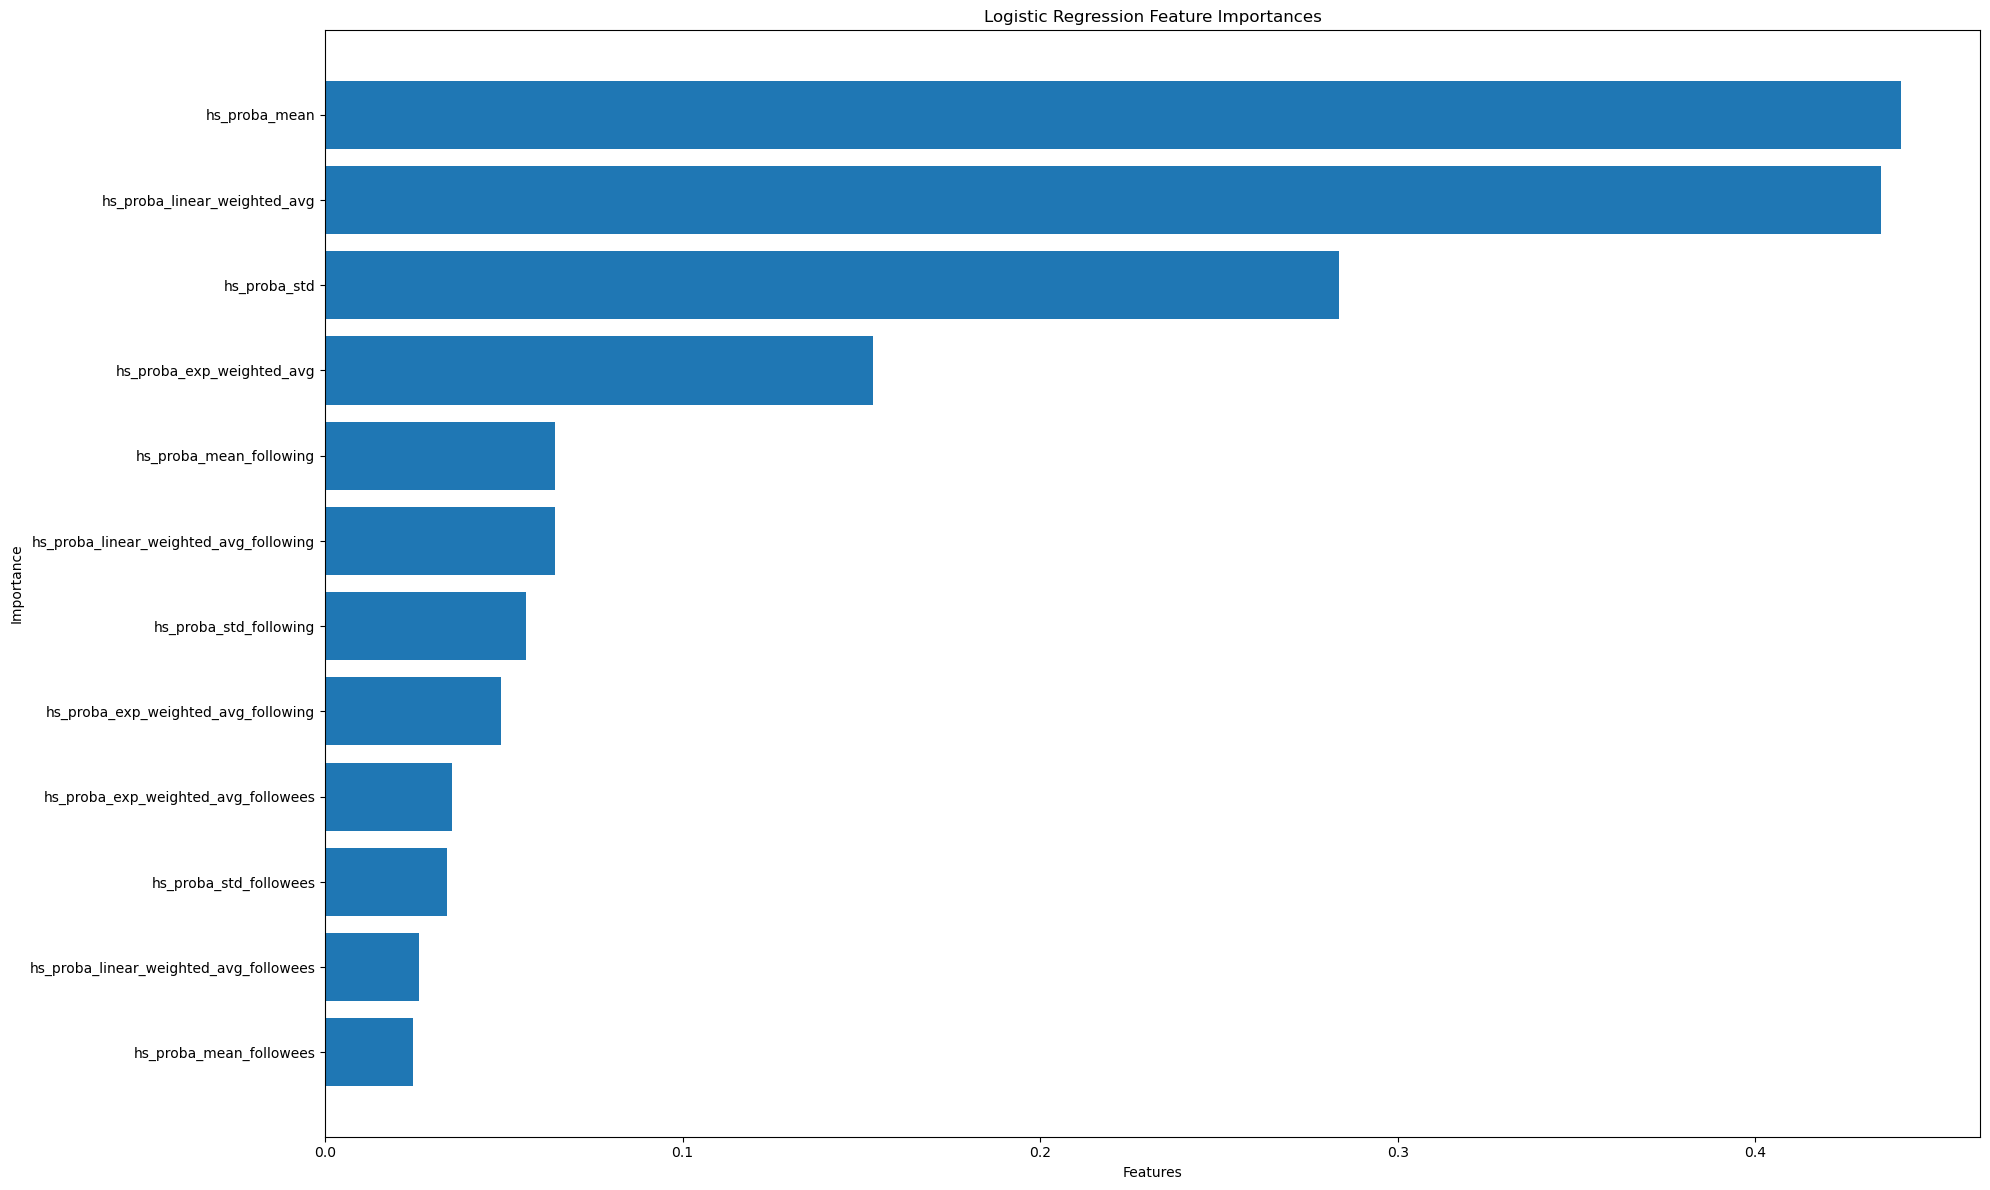

In [169]:
# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Logistic Regression Feature Importances')
plt.tight_layout()
plt.show()

In [170]:
X_ = gs.best_estimator_.steps[:-1][0][1].transform(X_transformed_relational)
# X = X_transformed_relational

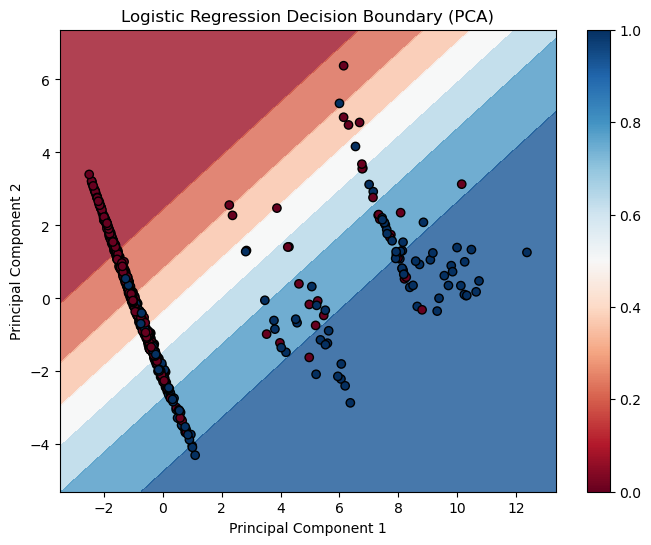

In [171]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_)

# Train a logistic regression model on the reduced dataset
# model = LogisticRegression()
model.fit(X_pca, y)

# Retrieve the coefficients and intercept
coef = model.coef_[0]
intercept = model.intercept_

# Define the range for the grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
h = 0.02  # step size in the mesh

# Generate a grid of points
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class probabilities for each point in the grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the decision boundary in the reduced feature space
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression Decision Boundary (PCA)')
plt.colorbar()
plt.show()

## XGBoost

In [240]:
def xgb_objective(trial, X, y, scoring=scoring):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "use_label_encoder": False,
        "n_jobs":30,
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 2.0, 5.0),
        "seed": seed
    }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 2, 6)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 20, 50, step=5)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["subsample"] = trial.suggest_float("subsample", 0.2, 0.8)
        params["colsample_bytree"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["colsample_bylevel"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["colsample_bynode"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Fit the model
    # pipe = make_pipeline(HateSpeechStatsTransformer(post_threshold=0.5,percentiles=[1,50,25,50,75,90,95,99]), StandardScaler(), xgb.XGBClassifier(**params))
    pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(**params))
    score = cross_val_score(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_name)
    # cv_results = cross_validate(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)
    # trial.set_user_attr("cv_results", cv_results)
    trial.set_user_attr("pipe", pipe)
    return score.mean()   
    # return cv_results[f'test_{scoring}'].mean()

In [242]:
import optuna.logging
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

sampler = TPESampler(**TPESampler.hyperopt_parameters(), seed=seed)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(lambda trial: xgb_objective(trial, X_, y_), n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [243]:
study.best_params

{'booster': 'gbtree',
 'lambda': 1.553160872043391e-08,
 'alpha': 0.08271682538048061,
 'scale_pos_weight': 3.2451619750678207,
 'max_depth': 6,
 'min_child_weight': 20,
 'eta': 0.004611371190612987,
 'subsample': 0.4504471906988525,
 'gamma': 0.1692078505959827,
 'grow_policy': 'lossguide'}

In [244]:
best_pipe = study.best_trial.user_attrs['pipe']
best_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.08271682538048061, base_score=None,
                               booster='gbtree',
                               colsample_bylevel=0.4504471906988525,
                               colsample_bynode=0.4504471906988525,
                               colsample_bytree=0.4504471906988525,
                               enable_categorical=False,
                               eta=0.004611371190612987, eval_metric='logloss',
                               gamma=0.1692078505959827, gp...
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None,
                               lambda=1.553160872043391e-08, learning_rate=None,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=20, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=30, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=3.2451619750678207,
                               seed=1740177118, ...))])

In [246]:
cv_results = cross_validate(best_pipe, X_, y_, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)

In [247]:
cv_results_df = pd.DataFrame.from_dict(cv_results)
cv_results_df = cv_results_df[[c for c in cv_results_df.columns if 'train' in c or 'test' in c]]
cv_results_df

test_accuracy  train_accuracy  test_precision  train_precision  \
0       0.758824        0.778434        0.520000         0.553719   
1       0.741176        0.787297        0.500000         0.562016   
2       0.715976        0.750737        0.473684         0.511864   
3       0.751479        0.713864        0.512500         0.472222   
4       0.739645        0.731563        0.500000         0.490741   

   test_recall  train_recall   test_f1  train_f1  test_roc_auc  train_roc_auc  
0     0.886364      0.761364  0.655462  0.641148      0.849567       0.862326  
1     0.613636      0.823864  0.551020  0.668203      0.837392       0.865116  
2     0.818182      0.857955  0.600000  0.641189      0.872000       0.860428  
3     0.931818      0.869318  0.661290  0.612000      0.891909       0.855793  
4     0.795455      0.903409  0.614035  0.636000      0.846182       0.870065

In [248]:
cv_results_mean_df = cv_results_df.agg(['mean', 'std']).T
cv_results_mean_df

mean       std
test_accuracy    0.741420  0.016238
train_accuracy   0.752379  0.030893
test_precision   0.501237  0.017615
train_precision  0.518112  0.039018
test_recall      0.809091  0.121967
train_recall     0.843182  0.053843
test_f1          0.616362  0.044972
train_f1         0.639708  0.019986
test_roc_auc     0.859410  0.022200
train_roc_auc    0.862746  0.005317

In [252]:
results_dict_dynamic_xgboost = {}
results_dict_dynamic_xgboost['train'] = cv_results_mean_df.loc[[i for i in cv_results_mean_df.index if 'train' in i]]
results_dict_dynamic_xgboost['test'] = cv_results_mean_df.loc[[i for i in cv_results_mean_df.index if 'test' in i]]

In [253]:
overleaf = ''
for m, s in results_dict_dynamic_xgboost['test'].astype(float).values:
    overleaf += (f'${m:.3f} \pm {s:.3f}$ & ')
print(overleaf[:-3] + '\\\\')

$0.741 \pm 0.016$ & $0.501 \pm 0.018$ & $0.809 \pm 0.122$ & $0.616 \pm 0.045$ & $0.859 \pm 0.022$\\


In [ ]:
for m, s in results_dict_dynamic['test'].astype(float).values:
    print(f'{m:.3f}+-{s:.3f}')

In [206]:
overleaf = ''
for m, s in results_dict_dynamic['test'].astype(float).values:
    overleaf += (f'${m:.3f} \pm {s:.3f}$ & ')
print(overleaf[:-3] + '\\\\')

$0.789 \pm 0.030$ & $0.570 \pm 0.043$ & $0.791 \pm 0.065$ & $0.661 \pm 0.038$ & $0.861 \pm 0.035$\\


## LightGBM

In [203]:
def lgb_objective(trial, X, y, scoring=scoring):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 0,
        "boosting_type": trial.suggest_categorical('boosting_type', ["gbdt", "dart"]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 16),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 50),
        "min_child_weight":trial.suggest_float("min_child_weight", 1, 1e1),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'min_split_gain': trial.suggest_float("min_split_gain", 1e-1, 1e2),
        "class_weight": "balanced",
        "silent": True,
        "n_jobs": 30,
        "random_state": seed,
        'importance_type': 'gain',
        'force_col_wise': True
    }

    pipe = make_pipeline(StandardScaler(), lgb.LGBMClassifier(**params))
    score = cross_val_score(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_name)
    trial.set_user_attr("pipe", pipe)
    return score.mean()   

In [204]:
import optuna.logging
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

sampler = TPESampler(**TPESampler.hyperopt_parameters(), seed=seed)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(lambda trial: lgb_objective(trial, X_transformed_relational, y), n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [205]:
study.best_params

{'boosting_type': 'gbdt',
 'reg_alpha': 0.0010733847812756426,
 'reg_lambda': 0.00011840045773375948,
 'num_leaves': 9,
 'max_depth': 3,
 'colsample_bytree': 0.43877933012516956,
 'subsample': 0.3069578079264763,
 'subsample_freq': 6,
 'min_child_samples': 22,
 'min_child_weight': 4.378129654858387,
 'min_split_gain': 1.2779740519092246}

In [206]:
best_pipe = study.best_trial.user_attrs['pipe']
best_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.43877933012516956,
                                force_col_wise=True, importance_type='gain',
                                max_depth=3, metric='binary_logloss',
                                min_child_samples=22,
                                min_child_weight=4.378129654858387,
                                min_split_gain=1.2779740519092246, n_jobs=30,
                                num_leaves=9, objective='binary',
                                random_state=1524604541,
                                reg_alpha=0.0010733847812756426,
                                reg_lambda=0.00011840045773375948, silent=True,
                                subsample=0.3069578079264763, subsample_freq=6,
                                verbosity=0))])

In [208]:
cv_results = cross_validate(best_pipe, X_transformed_relational, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [209]:
cv_results_df = pd.DataFrame.from_dict(cv_results)
cv_results_df = cv_results_df[[c for c in cv_results_df.columns if 'train' in c or 'test' in c]]
cv_results_df

test_accuracy  train_accuracy  test_precision  train_precision  \
0          0.935         0.92250        0.729730         0.686747   
1          0.920         0.93375        0.692308         0.721519   
2          0.945         0.92875        0.777778         0.714286   
3          0.910         0.92375        0.658537         0.693750   
4          0.915         0.92875        0.675000         0.701220   

   test_recall  train_recall   test_f1  train_f1  test_roc_auc  train_roc_auc  
0     0.900000      0.919355  0.805970  0.786207      0.981765       0.975830  
1     0.870968      0.926829  0.771429  0.811388      0.962970       0.981794  
2     0.903226      0.894309  0.835821  0.794224      0.955812       0.979128  
3     0.870968      0.902439  0.750000  0.784452      0.954953       0.977675  
4     0.870968      0.934959  0.760563  0.801394      0.945219       0.981999

In [210]:
cv_results_mean_df = cv_results_df.agg(['mean', 'std']).T
cv_results_mean_df

mean       std
test_accuracy    0.925000  0.014577
train_accuracy   0.927500  0.004507
test_precision   0.706670  0.047734
train_precision  0.703504  0.014335
test_recall      0.883226  0.016824
train_recall     0.915578  0.016893
test_f1          0.784757  0.035456
train_f1         0.795533  0.011149
test_roc_auc     0.960144  0.013637
train_roc_auc    0.979285  0.002656

# DeGroots Diffusion

In [ ]:
from detection.diffusion_method.degroots_diffusion import degroots_diffusion

In [50]:
import igraph as ig
import numpy as np

def degroots_diffusion(h, seed_hate_users=None, frac=None, size=None, initial_belief = 0.5, iterations=10, random_state=None):
    # hate_nodes_indices = seed_hate_users.indices
    g = h.copy()
    # g.reverse_edges()
    labeled_nodes = g.vs.select(lambda v: v['label']!=-1)
    if seed_hate_users is None:
        if size is None and frac is None:
            raise ValueError("Please pass a list of seed hate users or size/frac to sample from")
        if size is None:
            size = int(frac * len(labeled_nodes))
        np.random.seed(random_state)
        seed_hate_users = np.random.choice(labeled_nodes.indices, size, replace=False)
    initial_beliefs = np.full(g.vcount(), initial_belief)   
    initial_beliefs[seed_hate_users] = 1

    # Get the adjacency matrix as a numpy array
    A = np.array(g.get_adjacency(attribute='weight').data)
    
    # Normalize the adjacency matrix
    row_sums = A.sum(axis=1, where=(A > 0))  # Sum only where there are non-zero entries
    A_normalized = np.divide(A, row_sums[:, np.newaxis], out=np.zeros_like(A), where=row_sums[:, np.newaxis] != 0)
    history = [initial_beliefs.copy()]
    # Simulation of opinion dynamics
    for _ in range(iterations):
        beliefs = A_normalized.dot(history[-1])
        history.append(beliefs.copy())
    return history

In [51]:
h = largest_component_dict['gab']
display(h.summary())
labeled_nodes = h.vs.select(lambda v: v['label']!=-1)
y_true = labeled_nodes['label']
len(y_true)

'IGRAPH DNW- 21972 362479 -- gab\n+ attr: name (g), label (v), name (v), weight (e)'

785

In [52]:
g.summary()

'IGRAPH DNW- 4929 29943 -- echo_2\n+ attr: name (g), label (v), name (v), predictions (v), weight (e)'

In [53]:
labeled_nodes = g.vs.select(lambda v: v['label']!=-1)

In [236]:
order_k = 5

In [237]:
h_ = get_ego_subgraph(h, labeled_nodes, order_k=order_k)
labeled_nodes = h_.vs.select(lambda v: v['label']!=-1)
h_.summary()

'IGRAPH DNW- 10636 300094 -- gab\n+ attr: name (g), label (v), name (v), weight (e)'

In [176]:
y_true = labeled_nodes['label']
len(labeled_nodes)

233

In [200]:
seeds = np.random.randint(0, 2**32-1, 5)
seeds

array([4039516648, 2967554976, 1707558823, 1661015679, 2223725094])

In [244]:
%%time
histories = []
metrics = []
for seed in seeds:
    history = degroots_diffusion(h_, frac=0.05, iterations=10, initial_belief=0.5, random_state=seed)
    histories.append(history)
    
    labeled_nodes_opinions = history[-1][labeled_nodes.indices]
    # labeled_nodes_initial_opinions = history[0][labeled_nodes.indices]
    # labeled_nodes_opinions.mean(), labeled_nodes_initial_opinions.mean()

    # roc_auc_score(y_true, labeled_nodes_opinions), roc_auc_score(y_true, labeled_nodes_initial_opinions)

    scaler = MinMaxScaler()
    scaled_opinions = scaler.fit_transform(labeled_nodes_opinions.reshape(-1, 1)).flatten()

    preds = scaled_opinions >= 0.5
    metrics.append([accuracy_score(y_true, preds), precision_score(y_true, preds),  recall_score(y_true, preds),  f1_score(y_true, preds), roc_auc_score(y_true, labeled_nodes_opinions)])

CPU times: user 3min 2s, sys: 32.6 s, total: 3min 35s
Wall time: 2min 14s


In [239]:
results_df = pd.DataFrame(metrics, columns=['acccuracy', 'precision', 'recall', 'f1', 'roc_auc'], index=seeds)
results_df

acccuracy  precision    recall        f1   roc_auc
4039516648   0.494268   0.313112  0.776699  0.446304  0.604184
2967554976   0.498089   0.314961  0.776699  0.448179  0.603371
1707558823   0.494268   0.313112  0.776699  0.446304  0.603346
1661015679   0.494268   0.313112  0.776699  0.446304  0.603296
2223725094   0.499363   0.315582  0.776699  0.448808  0.603824

In [240]:
df = pd.concat([results_df.mean(axis=0), results_df.std(axis=0)], axis=1, names=['mean', 'std'])
df

0         1
acccuracy  0.496051  0.002483
precision  0.313975  0.001203
recall     0.776699  0.000000
f1         0.447180  0.001220
roc_auc    0.603604  0.000388

In [208]:
results_df = pd.DataFrame(metrics, columns=['acccuracy', 'precision', 'recall', 'f1', 'roc_auc'], index=seeds)
results_df

acccuracy  precision    recall        f1   roc_auc
4039516648   0.768240   0.720588  0.859649  0.784000  0.735294
2967554976   0.755365   0.717557  0.824561  0.767347  0.727628
1707558823   0.768240   0.711268  0.885965  0.789062  0.729102
1661015679   0.763948   0.709220  0.877193  0.784314  0.736400
2223725094   0.759657   0.726562  0.815789  0.768595  0.728365

In [214]:
df = pd.concat([results_df.mean(axis=0), results_df.std(axis=0)], axis=1, names=['mean', 'std'])
df

0         1
acccuracy  0.763090  0.005596
precision  0.717039  0.007036
recall     0.852632  0.031261
f1         0.778664  0.009975
roc_auc    0.731358  0.004149

In [243]:
s = ""
for mean, std in df.values:
    s += (f'& ${mean:.3f} \pm ${std:.3f}')
print(s)

& $0.496 \pm $0.002& $0.314 \pm $0.001& $0.777 \pm $0.000& $0.447 \pm $0.001& $0.604 \pm $0.000


In [105]:
arr = np.abs(labeled_nodes_opinions - labeled_nodes_initial_opinions)
k = 20
top_k_indices = np.argsort(arr)[-k:][::-1]

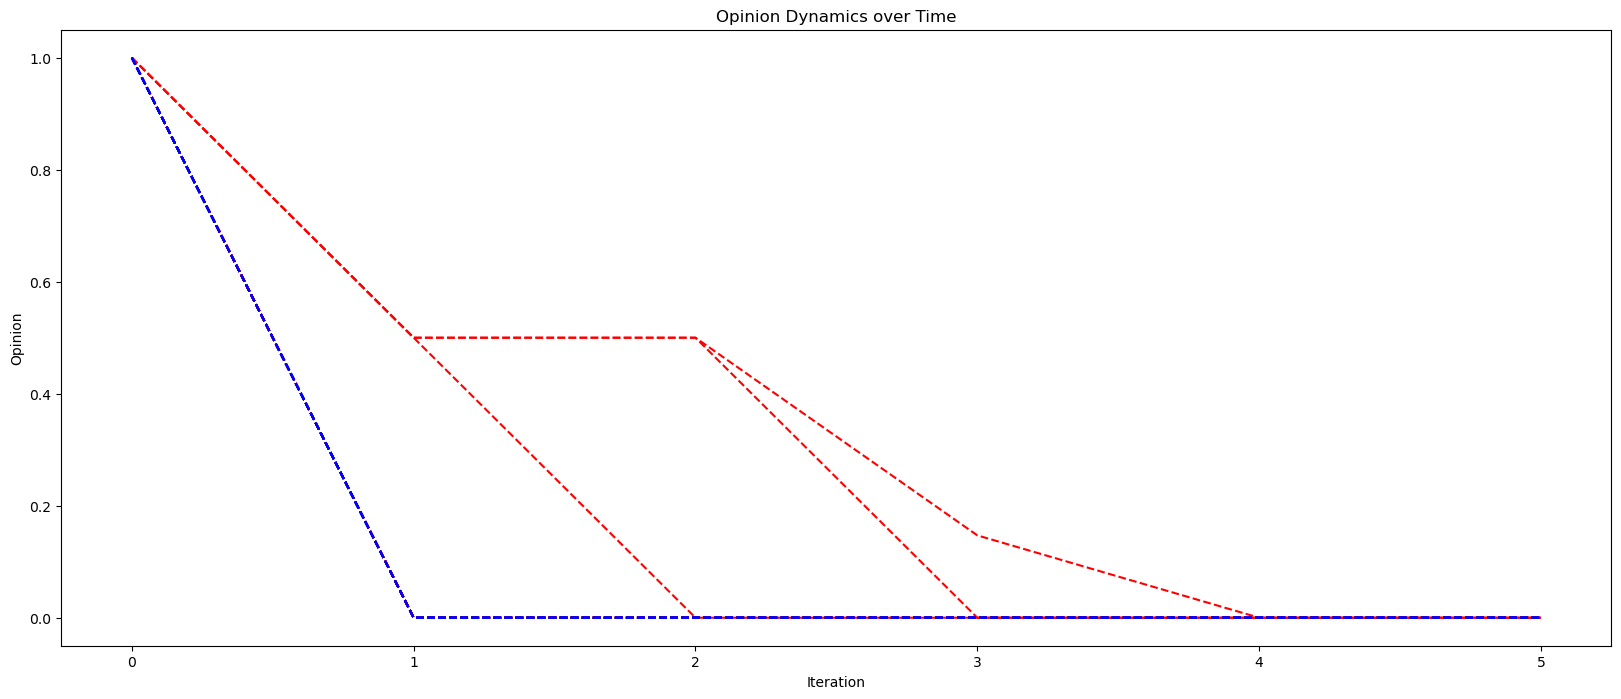

In [106]:
# Step 5: Plot the results
plt.figure(figsize=(20,8))
history_ = np.array(history)[:, labeled_nodes.indices]
for i in top_k_indices: #np.random.choice(labeled_nodes.indices, 50):
    plt.plot(history_[:, i], label=f'Node {i}', color='r' if labeled_nodes[i]['label']==1 else 'b' if labeled_nodes[i]['label']==0 else 'g', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.title('Opinion Dynamics over Time')
plt.xticks(range(len(history_)))
# plt.legend()
plt.show()

# GNN

In [54]:
np.random.seed(seed)

In [55]:
with open('/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p', 'rb') as f:
    doc2vec = pickle.load(f)

In [64]:
docs = np.array(list(doc2vec.values()))
print(docs.shape)
docs.mean(), docs.std()

(7073, 100)


(0.009456362, 2.4928932)

In [58]:
g.vs['doc2vec'] = [doc2vec.get(v['name'],  np.array(np.random.normal(mean, std, 100))) for v in g.vs]
# g.vs['doc2vec'] = [doc2vec.get(v['name'],  np.zeros(100)) for v in g.vs]

NameError: name 'mean' is not defined

In [57]:
vs_with_docs = g.vs.select(lambda v: v['doc2vec']!=[])

KeyError: 'Attribute does not exist'

In [572]:
vs_without_docs = g.vs.select(lambda v: v['doc2vec']==[])

In [574]:
# np.mean(list(doc2vec.values())), np.std(list(doc2vec.values()))
mean= np.mean(vs_with_docs['doc2vec'])
std= np.std(vs_with_docs['doc2vec'])
mean, std

(0.004867048635644196, 1.284237786228732)

In [534]:
len(vs_without_docs)

0

In [576]:
vs_without_docs.set_attribute_values('doc2vec', np.array(np.random.normal(mean, std, (len(vs_without_docs), 100))))

In [577]:
labeled_vs_with_docs = g.vs.select(lambda v: v['doc2vec']!=[] and v['label']!=-1)

In [578]:
len(vs_with_docs), len(labeled_vs_with_docs)

(4929, 233)

In [579]:
docs = np.array(g.vs['doc2vec'])
docs.shape

(4929, 100)

In [580]:
from sklearn.decomposition import PCA
import seaborn as sns

In [581]:
pca = PCA(n_components=2, random_state=seed)
docs_transformed = pca.fit_transform(docs)

In [582]:
node_colors = ['b' if v['label']==0 else 'r' if v['label']==1 else 'gray' for v in g.vs]
node_label= ['non_hate' if v['label']==0 else 'hate' if v['label']==1 else 'unlabeled' for v in g.vs]
len(node_colors)

4929

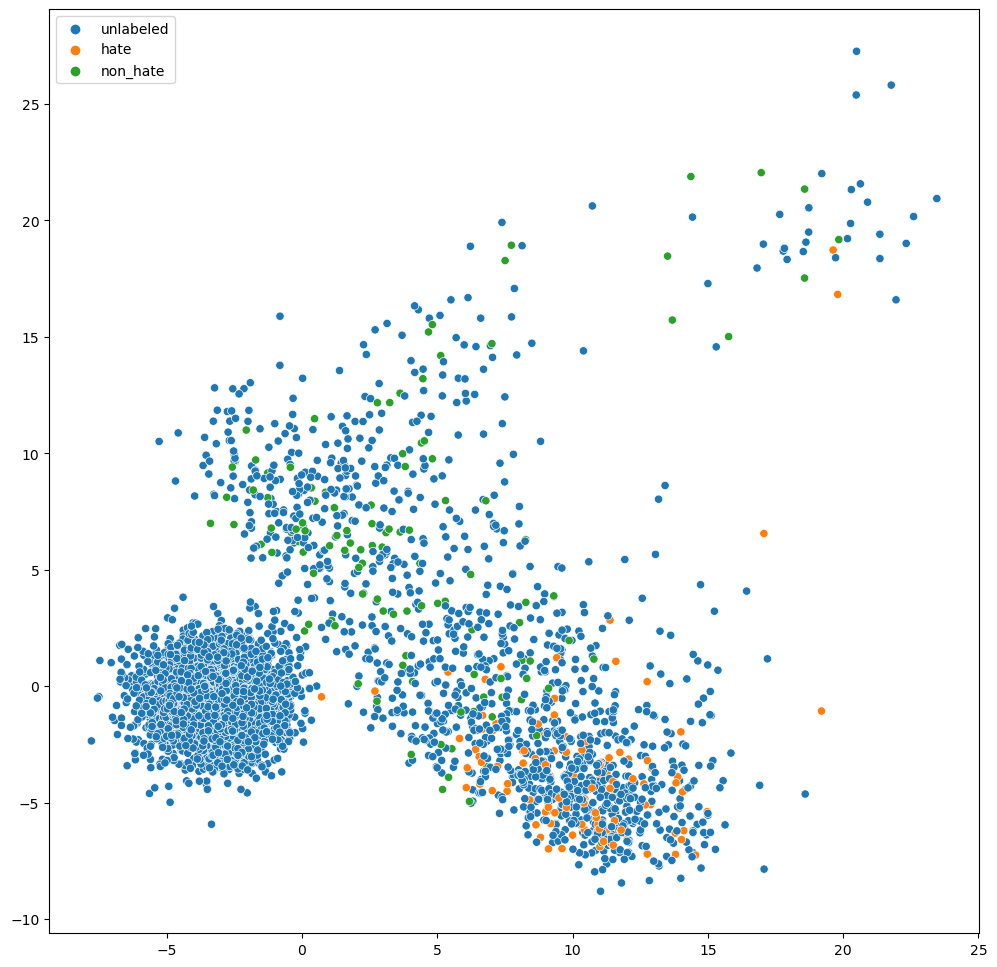

In [583]:
plt.figure(figsize=(12, 12))
sns.scatterplot(docs_transformed[:, 0], docs_transformed[:, 1], hue=node_label)
plt.show()